In [105]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as ply
import ipywidgets as iw
from oneibl import one
import brainbox.plot as bbp
from fitplot_funs import err_wght_sync
from export_funs import trialinfo_to_df

%matplotlib inline

fit_types = {'Stimulus on': 'stim',
             'Feedback': 'fdbck',
             'Prior estimate gain': 'prior',}

# Iterate though directories and find which mice/sessions we have fits for
mice = [x for x in os.listdir('./fits/') if os.path.isdir('./fits/' + x)]
fitsess = {mouse: [y[:-2] for y in os.listdir(f'./fits/{mouse}/') if y.split('.')[-1] == 'p'] for mouse in mice}

mousewidget = iw.Dropdown(options=mice)
sesswidget = iw.Dropdown()
cellwidget = iw.Dropdown()
fitwidget = iw.Dropdown()

def updatesess(*args):
    sesswidget.options = fitsess[mousewidget.value]
sesswidget.observe(updatesess)

mouse = 'ZM_2240'
sess = '2020-01-22_session_2020-05-05_probe0_fit.p'
probe_idx=0


fits = np.load(f'./fits/{mouse}/{sess}', allow_pickle=True)
wts_per_kern = fits['wts_per_kern']
kern_length = fits['kern_length']
binw = fits['glm_binsize']
uuid = fits['session_uuid']
p_est = fits['prior_est']
trdf = trialinfo_to_df(uuid, maxlen=2.)
one = one.ONE()
spikes = one.load(uuid, ['spikes.times'])[probe_idx]
clu = one.load(uuid, ['spikes.clusters'])[probe_idx]

Connected to https://alyx.internationalbrainlab.org as berk.gercek


In [106]:
percentile = 90# We should only show cells whose prior gain / gain estimate variance is above this percentile
fullfits = fits['fits']
fitdf = fullfits[np.isfinite(fullfits.prior)]
prior_threshold = np.percentile(np.abs(fitdf.prior / fitdf.varprior), percentile)
subsetdf = fitdf[np.abs(fitdf.prior / fitdf.varprior) > prior_threshold]
if 'bias' not in trdf.columns:
    trdf = trdf.join(p_est)
trdf = trdf[np.isfinite(trdf.bias)]

In [109]:
from matplotlib.colors import ListedColormap

SMALLER_SIZE = 16
SMALL_SIZE = 24
MEDIUM_SIZE = 28
BIGGER_SIZE = 36

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALLER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

@iw.interact
def plot_kern(cell=subsetdf.index.to_list(), kern=fit_types.keys()):
    fig, axes = plt.subplots(2, 1, figsize=(15, 9))
    currfit = fitdf.loc[cell]
    timescale = np.arange(0, kern_length, binw)
    if fit_types[kern] == 'stim':
        weight1 = np.ones_like(currfit['stim_R']) #currfit['stim_L']
        weight2 = currfit['stim_R']
        err2 = np.sqrt(err_wght_sync(currfit['varstim_R'], weight2))
        err1 = np.ones_like(err2)  #currfitnp.sqrt(err_wght_sync(currfit['varstim_L'], weight1))
        label1 = 'Left stimulus onset'
        label2 = 'Right stimulus onset'
        title = 'Kernels fit to right and left stimulus onset'
        event_t1 = trdf[np.isfinite(trdf.contrastLeft)].stimOn_times
        event_t2 = trdf[np.isfinite(trdf.contrastRight)].stimOn_times
    elif fit_types[kern] == 'fdbck':
        weight1 = currfit['fdbck_corr']
        weight2 = currfit['fdbck_incorr']
        err1 = err_wght_sync(currfit['varfdbck_corr'], weight1)
        err2 = err_wght_sync(currfit['varfdbck_incorr'], weight2)
        label1 = 'Correct feedback'
        label2 = 'Incorrect feedback'
        title = 'Kernels fit to correct and incorrect feedback'
        event_t1 = trdf[(trdf.feedbackType == 1) & np.isfinite(trdf.contrastRight)].stimOn_times
        event_t2 = trdf[(trdf.feedbackType == -1) & np.isfinite(trdf.contrastRight)].stimOn_times
    elif fit_types[kern] == 'prior':
        plt.close(fig)
        fig, axes = plt.subplots(1, 1, figsize=(15, 9))
        n_perc = 10
        cmap = sns.color_palette('GnBu_d', n_perc)
        percentiles = np.linspace(0, 100, n_perc + 1)
        percvals = np.percentile(trdf.bias, percentiles)
        print('Gain modulation of prior estimate:', currfit['prior'], 'Std dev of fit:', currfit['varprior'])
        for i in range(1, n_perc + 1):
            perctrials = trdf[(percvals[i-1] < trdf.bias) & (trdf.bias < percvals[i])].stimOn_times
            oldmin, oldmax = axes.get_ylim()
            bbp.peri_event_time_histogram(spikes, clu, perctrials, int(cell[4:]), t_before=0.4, t_after=0.6, ax=axes,
                                          error_bars='sem',
                                          pethline_kwargs={'color': cmap[i-1], 'lw': 2},
                                          errbar_kwargs={'color': cmap[i-1], 'alpha': 0.2})
            
            newmin, newmax = axes.get_ylim()
            axes.set_ylim([min((oldmin, newmin)), max((newmax, oldmax))])
            axes.set_yticks(axes.get_ylim())

        axes.set_title('PSTH about stim on for percentiles of prior estimate\n'
                       'GLM gain term: {:.2f}, Std. dev. of term: {:.2f}'.format(currfit['prior'], currfit['varprior']))
        axes.set_xlabel('Time (s)')
        axes.set_ylabel('Firing rate')
#         axes.legend()
        plt.tight_layout()
        return
    bbp.peri_event_time_histogram(spikes, clu, event_t1, int(cell[4:]), t_before=0., t_after=0.6, ax=axes[0],
                                  error_bars='sem',
                                  pethline_kwargs={'color': 'navy', 'lw': 2, 'label': label1 + ' PSTH'},
                                  errbar_kwargs={'color': 'navy', 'alpha': 0.2})
    ymin1, ymax1 = axes[0].get_yticks()[1:]
    bbp.peri_event_time_histogram(spikes, clu, event_t2, int(cell[4:]), t_before=0., t_after=0.6, ax=axes[0],
                                  error_bars='sem',
                                  pethline_kwargs={'color': 'orange', 'lw': 2, 'label': label2 + ' PSTH'},
                                  errbar_kwargs={'color': 'orange', 'alpha': 0.2})
    ymin2, ymax2 = axes[0].get_yticks()[1:]
    axes[0].set_ylim([min((ymin1, ymin2)), max((ymax1, ymax2))])
    axes[0].legend()
    
    axes[0].set_title(f'PSTH about {kern}')
    plt.autoscale(axes[0])
    axes[1].errorbar(timescale, weight1, yerr=err1, label=label1)
    axes[1].errorbar(timescale, weight2, yerr=err2, label=label2)
    axes[1].legend()
    axes[1].set_xlabel('Time (s)')
    axes[1].set_ylabel('Kernel value')
    axes[1].set_title(title)
    plt.tight_layout()
    # Bizarre fits: cell253, cell302
    

interactive(children=(Dropdown(description='cell', options=('cell17', 'cell108', 'cell109', 'cell117', 'cell11…

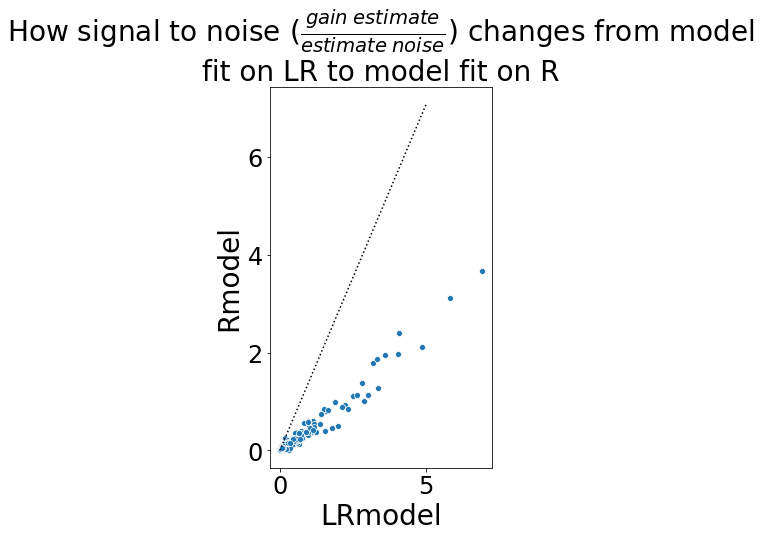

In [124]:
oldfits = np.load(f'./fits/ZM_2240/2020-01-22_session_2020-04-20_probe0_fit.p', allow_pickle=True)
oldfits = oldfits['fits']
olddf = oldfits[np.isfinite(oldfits.prior)]
newsnr = np.abs(fitdf.prior / fitdf.varprior)
oldsnr = np.abs(olddf.prior / olddf.varprior)
compdf = pd.concat([oldsnr, newsnr], axis=1, sort=True)
compdf.rename(columns={0: 'LRmodel', 1: 'Rmodel'}, inplace=True)
compdf = compdf.astype(float)
compdf[(compdf.LRmodel > 1e-3) & (compdf.Rmodel > 1e-3)]
sigdf = compdf[(compdf.LRmodel > 1e-3) & (compdf.Rmodel > 1e-3)]
logdf = np.log(sigdf)
plt.figure(figsize=(8, 8))
ax = sns.scatterplot(x='LRmodel', y='Rmodel', data=sigdf)
ax.plot([0, 5], np.sqrt(2) * np.array([0, 5]), ':k')
plt.title(r'How signal to noise ($\frac{gain \; estimate}{estimate \; noise}$) changes from model' + '\n' +
          'fit on LR to model fit on R')
plt.tight_layout()

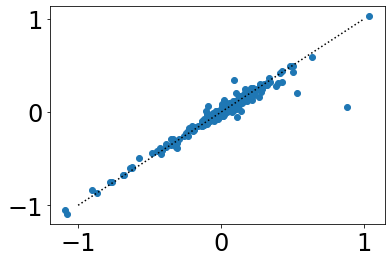

In [123]:
valdf = pd.concat([fitdf['prior'], oldfits['prior']], axis=1, sort=True)
valdf = valdf[np.isfinite(valdf.values[:, 0])]
plt.scatter(x=valdf.values[:, 0], y=valdf.values[:, 1])
plt.plot([-1, 1], [-1, 1], ':k')

In [ ]:
1000